In [1]:
!pip install spacy

DEPRECATION: Loading egg at c:\users\hp\anaconda3\lib\site-packages\huggingface_hub-0.19.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [2]:
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import spacy

In [3]:
# character name
# data of character name & gender
df = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None)
df_name_gender = df.iloc[:, [3, 5]].dropna()
df_name_gender.columns = ['Name','Gender']
print(df_name_gender.head(5))

                         Name Gender
0                    Akooshay      F
1  Lieutenant Melanie Ballard      F
2         Desolation Williams      M
3          Sgt Jericho Butler      M
4             Bashira Kincaid      F


In [4]:
# build a name dict
name_list = df.iloc[:, [3]].dropna()
name_list=name_list.squeeze().tolist()
name_dict = set()
for item in list(name_list):
    names = item.split()
    for name in names:
            name_dict.add(name.lower())

In [5]:
# English vocabulary specific to a certain gender
# female_nouns.txt contains common words that are only used to refer to females, like 'mother'
female_words=set()
with open('data/female_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                female_words.add(word.lower())                
                
# male_nouns.txt contains common words that are only used to refer to males, like 'uncle'     
male_words=set()
with open('data/male_nouns.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                male_words.add(word.lower())

In [6]:
# Define a list of words representing females/males
# females
df_female_name = df_name_gender[df_name_gender['Gender']=='F']['Name']
female_name_dict = set()
for item in df_female_name:
    names = item.split()
    for name in names:
        # remove the names like 'Alice's father' that can have a negative impact on the result
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                female_name_dict.add(name.lower())
female_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in female_name_dict]


# males
df_male_name = df_name_gender[df_name_gender['Gender']=='M']['Name']
male_name_dict = set()
for item in df_male_name:
    names = item.split()
    for name in names:
        if not name.lower() in female_words | male_words:
            if not name.lower().endswith("'s"):
                male_name_dict.add(name.lower())
male_cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in male_name_dict]

In [7]:
#some characters have the same family name but different gender,remove the family names
female_name_dict_cleaned = set(female_cleaned_list)
male_name_dict_cleaned = set(male_cleaned_list)

intersection_set = male_name_dict_cleaned & female_name_dict_cleaned
male_name_dict = male_name_dict_cleaned - intersection_set
female_name_dict = female_name_dict_cleaned - intersection_set
cleaned_list = [re.sub('[^a-zA-Z]', '', s) for s in name_dict]
print(len(cleaned_list))
cleaned_list = set(cleaned_list) - intersection_set
print(len(cleaned_list))

68422
53838


In [8]:
# code for storing the names
'''with open('data/names from movies.txt', 'w', encoding='utf-8') as file:
    for item in cleaned_list:
        file.write(item + '\n')
with open('data/female_name_dict1.txt', 'w', encoding='utf-8') as file:
    for name in female_name_dict:
        file.write(name + '\n')
with open('data/male_name_dict1.txt', 'w', encoding='utf-8') as file:
    for name in male_name_dict:
        file.write(name + '\n')'''

"with open('data/names from movies.txt', 'w', encoding='utf-8') as file:\n    for item in cleaned_list:\n        file.write(item + '\n')\nwith open('data/female_name_dict1.txt', 'w', encoding='utf-8') as file:\n    for name in female_name_dict:\n        file.write(name + '\n')\nwith open('data/male_name_dict1.txt', 'w', encoding='utf-8') as file:\n    for name in male_name_dict:\n        file.write(name + '\n')"

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# data preprocessing
# Set the stopwords
stop_words = set(stopwords.words('english'))

# a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict

# remove adjs in the name list
adjs_set = set()
with open('data/common_adjs.txt', 'r') as file:
    for line in file:
        word = line.strip().lower()
        adjs_set.add(word)
female_names_words = female_names_words - adjs_set
male_names_words = male_names_words - adjs_set

# function used to tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return ['she' if word in female_names_words else 'he' if word in male_names_words else word for word in text.split() if word not in stop_words]

# apply the fuction to the summaries
documents = []
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    for line in file:
        _, text = line.split('\t', 1)
        processed_text = preprocess_text(text)
        documents.append(processed_text)

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# code to extract adjs(the outcome is stored in data/adjectives.txt, so you can skip this)
# 
female_name_dict = []
with open('data/female_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        female_name_dict.append(line.strip())
female_name_dict=set(female_name_dict)
male_name_dict = []
with open('data/male_name_dict1.txt', 'r', encoding='utf-8') as file:
    for line in file:
        male_name_dict.append(line.strip())
male_name_dict=set(male_name_dict)

#
# data preprocessing, very time-consuming

# Define a list of words representing females/males
female_names_words = female_words | female_name_dict
male_names_words = male_words | male_name_dict
remove_dict=(stop_words | female_names_words | male_names_words)
#from https://www.merriam-webster.com/thesaurus/

def preprocess_text_adj(text):
    # lower the words and remove punctuation
    text_token = word_tokenize(text)
    tagged = pos_tag(text_token)
    adjectives = [word for word, pos in tagged if (pos.startswith('JJ'))]
    text = [word.lower() for word in adjectives if word.isalpha()]
    # tokenize, replace words representing females with 'she' and males with 'he', and remove stopwords.
    return [word for word in text if word not in remove_dict]


documents_adj=[]
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    for line in file:
        text = line
        documents_adj.append(preprocess_text_adj(text))
documents_adj = [word for sublist in documents_adj for word in sublist]

vocabulary=list(set(documents_adj))
word_counts = {word: documents_adj.count(word) for word in vocabulary}
word_count_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Count'])
# only use the words appear at least twice
documents_adj=list(word_count_df[word_count_df['Count']>1]['Word'])

In [14]:
# remove some words in case of incorrect classification
lines = []

# file from https://www.cs.cmu.edu/afs/cs/project/ai-repository/ai/areas/nlp/corpora/names/
with open('data/female name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)

lines = []
with open('data/male name.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents_adj = set(documents_adj)-set(lines)


lines = []
'''with open('data/names from movies.txt', 'r', encoding='utf-8') as file:
    for line in file:
        line=line.lower()
        lines.append(line.strip())
documents = set(documents)-(set(lines) & set(documents))'''

print(len(documents_adj))
other_common_words = set(['child', 'orphan', 'baby', 'girls', 'lover', 'mute','child', 'orphan', 'bride', 
                          'baby', 'girls', 'lover', 'mute', 'housekeeper', 'cousin', 'neighbour', 'parent', 
                          'sibling', 'pregnant', 'housewife', 'relative', 'servant', 'waif', 'grandson', 
                          'stranger', 'courtesan', 'servant','cousin', 'neighbour', 'parent', 'sibling', 
                          'housewife','nurse', 'stepsister', 'housekeeper','grandson','servant','grandchildren',
                          'relatives', 'uncles', 'orphans', 'childbirth', 'scoundrel', 'foreigner', 'stepfamily', 
                          'tuberculosis', 'mallaya', 'triplet', 'grandchildren', 'outcast', 'neighbours', 'huanhuan', 
                          'lakshmiammal', 'jaipal', 'himal', 'pasarian', 'leukemia'])
documents_adj = set(documents_adj)-set(other_common_words)

8671


In [15]:
# save data
with open('data/adjectives.txt', 'w', encoding='utf-8') as file:
    for item in documents_adj:
        file.write(item + '\n')

In [16]:
# load the data adjectives.txt (extracted from the text)
adjectives = []
with open('data/adjectives.txt', 'r', encoding='utf-8') as file:
    for line in file:
        adjectives.append(line.strip())

In [17]:
# train the word2vec model
model = Word2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

# save the model
model.save("word2vec.model")

In [18]:
# apply the model
model = Word2Vec.load("word2vec.model")
adjectives = [word for word in adjectives if word in model.wv.key_to_index]
adj_vectors = [model.wv[word] for word in adjectives]
vector_she = model.wv['she']
vector_he = model.wv['he']

In [19]:
# example: lovely
similarity = cosine_similarity(vector_she.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between female and lovely: {similarity}')
similarity = cosine_similarity(vector_he.reshape(1,-1), model.wv['lovely'].reshape(1,-1))
print(f'similarity between male and lovely: {similarity}')

similarity between female and lovely: [[0.43518674]]
similarity between male and lovely: [[0.19401294]]


In [20]:
female_reference_vector = vector_she.reshape(1, -1)
female_similarities = [cosine_similarity(female_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]
male_reference_vector = vector_he.reshape(1, -1)
male_similarities = [cosine_similarity(male_reference_vector, vec.reshape(1, -1))[0][0] for vec in adj_vectors]

In [21]:
similaritie = pd.DataFrame({'Female':female_similarities,'Male':male_similarities})
similaritie.index=adjectives
print(similaritie)

             Female      Male
blow       0.206204  0.446524
tentacled  0.020400  0.092049
astray     0.163680  0.188895
ygor       0.360471  0.352739
begs       0.361918  0.312979
...             ...       ...
radical   -0.053792 -0.047078
clawed     0.151467  0.243019
subhuman  -0.010382 -0.045736
parted     0.232771  0.169359
dancer     0.229739  0.072522

[8646 rows x 2 columns]


In [22]:
similarity_diff=similaritie['Female']-similaritie['Male']
top_100_female_adj = similarity_diff.sort_values(ascending=False).head(100).index
print(top_100_female_adj)
top_100_male_adj = similarity_diff.sort_values(ascending=True).head(100).index
print(top_100_male_adj)

Index(['unhappy', 'worrisome', 'loving', 'shy', 'beautiful', 'lonely', 'older',
       'caring', 'neighbor', 'sweetheart', 'lovely', 'overprotective',
       'promiscuous', 'fiancé', 'unmarried', 'intimate', 'lifestyle',
       'precocious', 'somewhat', 'metaphoric', 'deeply', 'younger', 'teenage',
       'neglected', 'divorced', 'twin', 'deaf', 'fiancée', 'desire',
       'passionate', 'grown', 'domineering', 'affair', 'sexual', 'cheerful',
       'loved', 'charming', 'depressed', 'loneliness', 'overbearing',
       'behaviour', 'disturbed', 'shared', 'flirtatious', 'paternal',
       'insecure', 'therapist', 'attracted', 'teenager', 'emotional',
       'jealousy', 'adopted', 'nun', 'autistic', 'enthused', 'spoiled',
       'insensitive', 'deferral', 'roommate', 'premarital', 'embarrassed',
       'attachment', 'fond', 'household', 'uncomfortable', 'genuinely',
       'socialite', 'unwed', 'smitten', 'intrigued', 'reconciled',
       'incestuous', 'repressed', 'flighty', 'urbanite', '

In [23]:
!pip install wordcloud

DEPRECATION: Loading egg at c:\users\hp\anaconda3\lib\site-packages\huggingface_hub-0.19.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


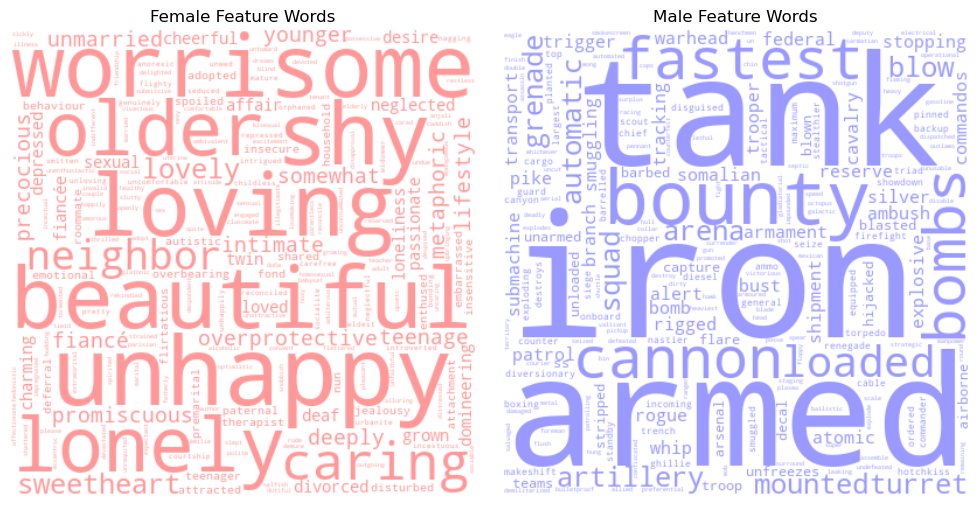

In [24]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

word_sim_female = {word: sim for word, sim in similarity_diff.items()}
word_sim_male = {word: -sim for word, sim in similarity_diff.items()}

wordcloud_female = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: '#ff9999').generate_from_frequencies(word_sim_female)
wordcloud_male = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: '#9999ff').generate_from_frequencies(word_sim_male)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_female, interpolation='bilinear')
plt.title('Female Feature Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_male, interpolation='bilinear')
plt.title('Male Feature Words')
plt.axis('off')

plt.tight_layout()
plt.show()

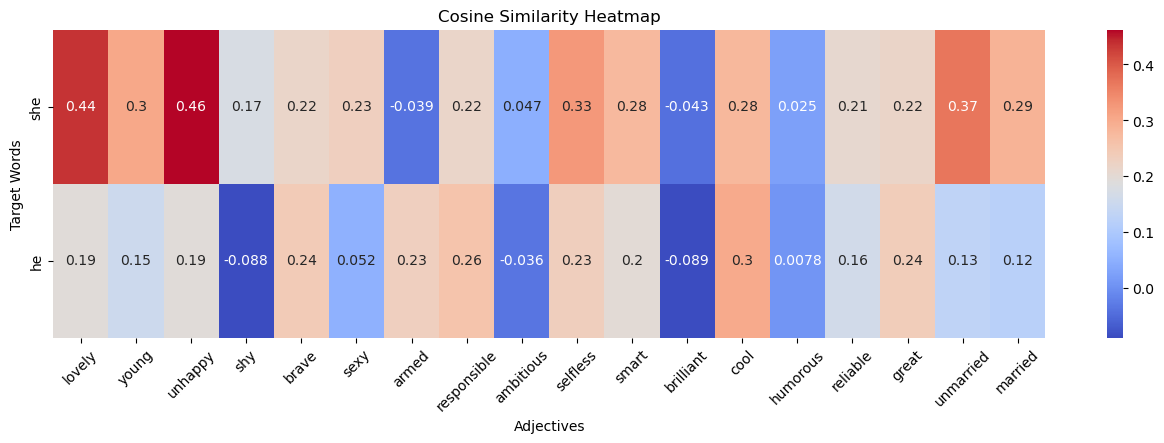

In [25]:
# heatmap
target_words = ["she", "he"]
target_words_vectors = np.array([
    vector_she,
    vector_he
])

adjectives_samples = ["lovely", "young", "unhappy", "shy", "brave", "sexy", "armed", "responsible","ambitious","selfless",
              "smart", "brilliant", "cool", "humorous", "reliable", "great","unmarried","married"]
adjectives_samples_vectors = np.array([model.wv[adj] for adj in adjectives_samples])

# cosine_similarity
cos_sim_matrix = cosine_similarity(np.vstack((target_words_vectors, adjectives_samples_vectors)))
cos_sim_matrix = cos_sim_matrix[:2, 2:]

plt.figure(figsize=(16, 4))
sns.heatmap(cos_sim_matrix, annot=True, cmap='coolwarm', xticklabels=adjectives_samples, yticklabels=target_words)
plt.title("Cosine Similarity Heatmap")
plt.ylabel("Target Words")
plt.xlabel("Adjectives")
plt.xticks(rotation=45)  # for easy reading
plt.show()

In [26]:
top_100_female_adj_list = top_100_female_adj.astype(str).tolist()
top_100_male_adj_list = top_100_male_adj.astype(str).tolist()

print(top_100_female_adj_list)
print(top_100_male_adj_list)

['unhappy', 'worrisome', 'loving', 'shy', 'beautiful', 'lonely', 'older', 'caring', 'neighbor', 'sweetheart', 'lovely', 'overprotective', 'promiscuous', 'fiancé', 'unmarried', 'intimate', 'lifestyle', 'precocious', 'somewhat', 'metaphoric', 'deeply', 'younger', 'teenage', 'neglected', 'divorced', 'twin', 'deaf', 'fiancée', 'desire', 'passionate', 'grown', 'domineering', 'affair', 'sexual', 'cheerful', 'loved', 'charming', 'depressed', 'loneliness', 'overbearing', 'behaviour', 'disturbed', 'shared', 'flirtatious', 'paternal', 'insecure', 'therapist', 'attracted', 'teenager', 'emotional', 'jealousy', 'adopted', 'nun', 'autistic', 'enthused', 'spoiled', 'insensitive', 'deferral', 'roommate', 'premarital', 'embarrassed', 'attachment', 'fond', 'household', 'uncomfortable', 'genuinely', 'socialite', 'unwed', 'smitten', 'intrigued', 'reconciled', 'incestuous', 'repressed', 'flighty', 'urbanite', 'seduced', 'mature', 'orphaned', 'neglectful', 'nagging', 'carefree', 'widower', 'courtship', 'ano

In [27]:
#use BERT to do sentimental analysis

!pip install transformers
!pip install xformer

DEPRECATION: Loading egg at c:\users\hp\anaconda3\lib\site-packages\huggingface_hub-0.19.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


DEPRECATION: Loading egg at c:\users\hp\anaconda3\lib\site-packages\huggingface_hub-0.19.4-py3.8.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


In [28]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")


top_100_female_sentiments = sentiment_pipeline(top_100_female_adj_list)
top_100_male_sentiments = sentiment_pipeline(top_100_male_adj_list)

print("Female sentiments:", top_100_female_sentiments)
print("Male sentiments:", top_100_male_sentiments)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Female sentiments: [{'label': 'NEGATIVE', 'score': 0.999789297580719}, {'label': 'NEGATIVE', 'score': 0.9997269511222839}, {'label': 'POSITIVE', 'score': 0.9998767375946045}, {'label': 'NEGATIVE', 'score': 0.9961496591567993}, {'label': 'POSITIVE', 'score': 0.9998807907104492}, {'label': 'NEGATIVE', 'score': 0.9994705319404602}, {'label': 'NEGATIVE', 'score': 0.9919120073318481}, {'label': 'POSITIVE', 'score': 0.9997088313102722}, {'label': 'POSITIVE', 'score': 0.9962518811225891}, {'label': 'POSITIVE', 'score': 0.999849796295166}, {'label': 'POSITIVE', 'score': 0.9998601675033569}, {'label': 'NEGATIVE', 'score': 0.9992198944091797}, {'label': 'NEGATIVE', 'score': 0.9821943044662476}, {'label': 'POSITIVE', 'score': 0.9946873188018799}, {'label': 'NEGATIVE', 'score': 0.9716919660568237}, {'label': 'POSITIVE', 'score': 0.9998170733451843}, {'label': 'POSITIVE', 'score': 0.9985740184783936}, {'label': 'NEGATIVE', 'score': 0.9885442852973938}, {'label': 'POSITIVE', 'score': 0.9876153469085

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 29.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


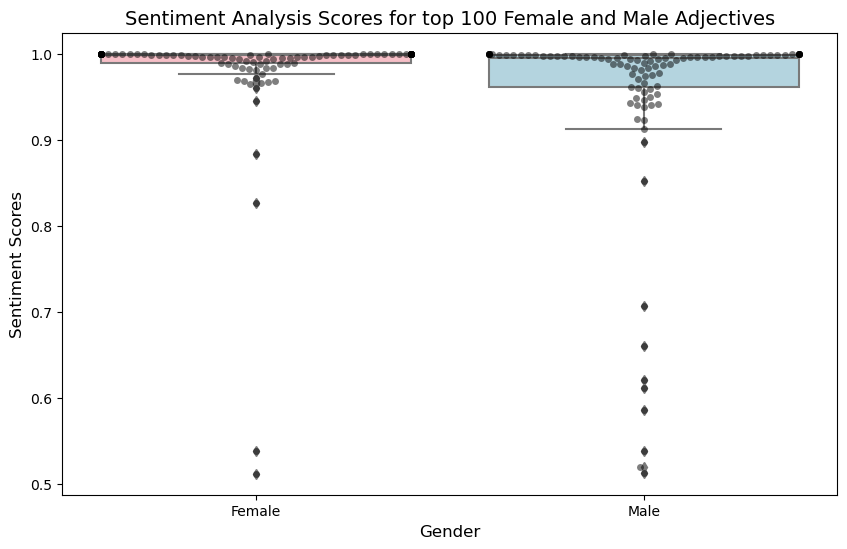

In [29]:
female_scores = [sentiment['score'] for sentiment in top_100_female_sentiments]
male_scores = [sentiment['score'] for sentiment in top_100_male_sentiments]

df = pd.DataFrame({'Gender': ['Female']*len(female_scores) + ['Male']*len(male_scores),
                   'Score': female_scores + male_scores})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Score', data=df, palette=["lightpink", "lightblue"])

sns.swarmplot(x='Gender', y='Score', data=df, color='black', alpha=0.5)

plt.title('Sentiment Analysis Scores for top 100 Female and Male Adjectives', fontsize=14)
plt.ylabel('Sentiment Scores', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [30]:
def sentiment_proportions(sentiments):
    # Count the number of positive and negative sentiments
    positive = sum(1 for sentiment in sentiments if sentiment['label'] == 'POSITIVE')
    negative = sum(1 for sentiment in sentiments if sentiment['label'] == 'NEGATIVE')
    total = positive + negative
    # Calculate the proportions
    positive_proportion = positive / total
    negative_proportion = negative / total
    return positive_proportion, negative_proportion

top_100_female_positive, top_100_female_negative = sentiment_proportions(top_100_female_sentiments)
top_100_male_positive, top_100_male_negative = sentiment_proportions(top_100_male_sentiments)

print(f"Female Positive: {top_100_female_positive:.2f}, Female Negative: {top_100_female_negative:.2f}")
print(f"Male Positive: {top_100_male_positive:.2f}, Male Negative: {top_100_male_negative:.2f}")

Female Positive: 0.53, Female Negative: 0.47
Male Positive: 0.54, Male Negative: 0.46


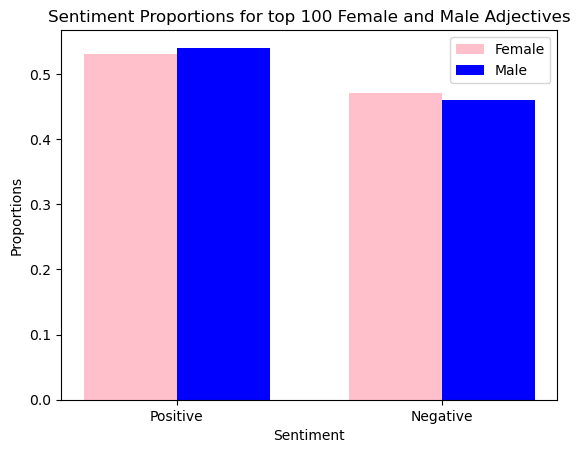

In [31]:
# Sentiment proportions data

categories = ['Positive', 'Negative']
female_proportions = [top_100_female_positive, top_100_female_negative]
male_proportions = [top_100_male_positive, top_100_male_negative]

fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, female_proportions, bar_width, label='Female', color='pink')
bar2 = ax.bar([i + bar_width for i in index], male_proportions, bar_width, label='Male', color='blue')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Proportions')
ax.set_title('Sentiment Proportions for top 100 Female and Male Adjectives')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

plt.show()

The significantly higher proportion of negative sentiments in female-associated adjectives and a correspondingly lower proportion of negative sentiments in male-associated adjectives suggest the presence of gender bias in the dataset or in societal perceptions.

These results may reflect existing gender stereotypes in society. Language often mirrors societal attitudes, and this could be a manifestation of underlying biases.

In [32]:
def average_sentiment_score(sentiments):
    # Calculate the average score
    scores = [sentiment['score'] for sentiment in sentiments]
    average_score = sum(scores) / len(scores)
    return average_score

top_100_female_avg_score = average_sentiment_score(top_100_female_sentiments)
top_100_male_avg_score = average_sentiment_score(top_100_male_sentiments)

print(f"Average sentiment score for female adjectives: {top_100_female_avg_score:.2f}")
print(f"Average sentiment score for male adjectives: {top_100_male_avg_score:.2f}")

Average sentiment score for female adjectives: 0.98
Average sentiment score for male adjectives: 0.95


This suggests that even though female adjectives have more negative sentiments, their average sentiment score is high. This could mean that the positive sentiments are very strong. For male adjectives, there's a higher proportion of positive sentiments, but the average score is slightly lower.

We may ckeck in a bigger dataset, not only the top 100 to analyze the question in a broader way. (same methods

In [33]:
# Words more related to females, which are words where the value in similarity_diff is positive, 
all_female_adj = similarity_diff[similarity_diff > 0].sort_values(ascending=False).index.tolist()

# Words more related to males, which are words where the value in similarity_diff is negative, 
all_male_adj = similarity_diff[similarity_diff < 0].sort_values(ascending=True).index.tolist()

In [34]:
female_all_sentiments = sentiment_pipeline(all_female_adj)
male_all_sentiments = sentiment_pipeline(all_male_adj)

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 77.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 76.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 77.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 76.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


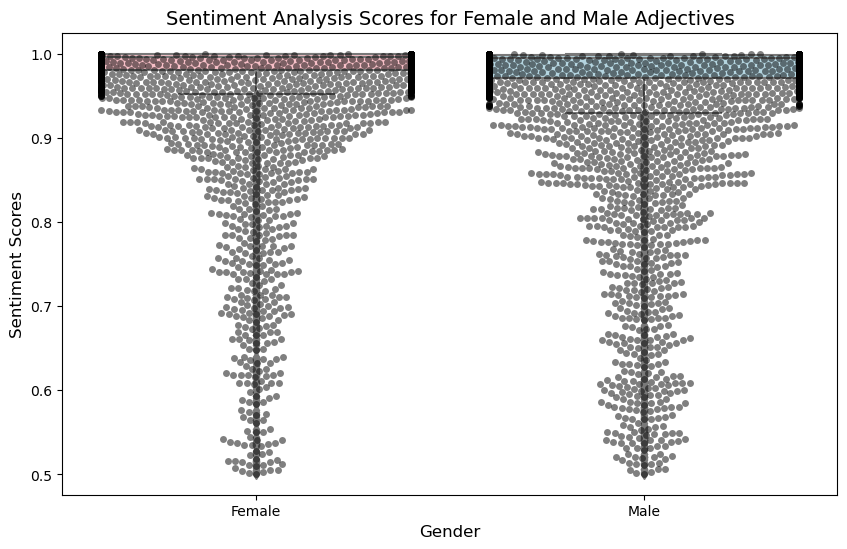

In [35]:
female_scores = [sentiment['score'] for sentiment in female_all_sentiments]
male_scores = [sentiment['score'] for sentiment in male_all_sentiments]

df = pd.DataFrame({'Gender': ['Female']*len(female_scores) + ['Male']*len(male_scores),
                   'Score': female_scores + male_scores})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Gender', y='Score', data=df, palette=["lightpink", "lightblue"])

sns.swarmplot(x='Gender', y='Score', data=df, color='black', alpha=0.5)

plt.title('Sentiment Analysis Scores for Female and Male Adjectives', fontsize=14)
plt.ylabel('Sentiment Scores', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [36]:
female_all_positive, female_all_negative = sentiment_proportions(female_all_sentiments)
male_all_positive, male_all_negative = sentiment_proportions(male_all_sentiments)

print(f"All Female Positive: {female_all_positive:.2f}, All Female Negative: {female_all_negative:.2f}")
print(f"All Male Positive: {male_all_positive:.2f}, All Male Negative: {male_all_negative:.2f}")

All Female Positive: 0.53, All Female Negative: 0.47
All Male Positive: 0.55, All Male Negative: 0.45


When we broaden the dataset. Although the data for both groups are broadly similar, the positive sentiment associated with male-related adjectives is slightly higher than that for female-related adjectives. While this difference exists, it is not particularly significant. 

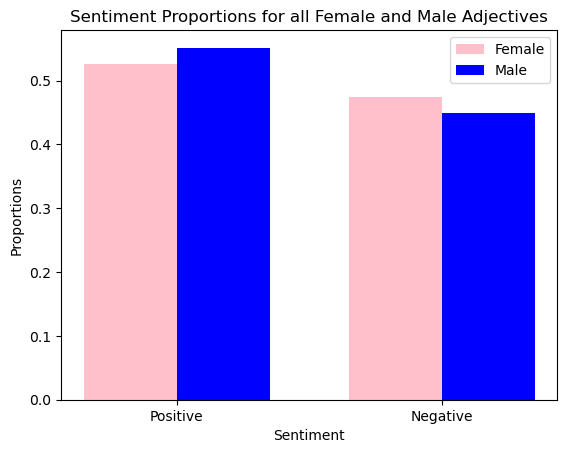

In [37]:
# Sentiment proportions data

categories = ['Positive', 'Negative']
female_proportions = [female_all_positive, female_all_negative]
male_proportions = [male_all_positive, male_all_negative]

fig, ax = plt.subplots()

bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, female_proportions, bar_width, label='Female', color='pink')
bar2 = ax.bar([i + bar_width for i in index], male_proportions, bar_width, label='Male', color='blue')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Proportions')
ax.set_title('Sentiment Proportions for all Female and Male Adjectives')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

plt.show()

In [38]:
female_all_avg_score = average_sentiment_score(female_all_sentiments)
male_all_avg_score = average_sentiment_score(male_all_sentiments)

print(f"Average sentiment score for all female adjectives: {female_all_avg_score:.2f}")
print(f"Average sentiment score for all male adjectives: {male_all_avg_score:.2f}")

Average sentiment score for all female adjectives: 0.97
Average sentiment score for all male adjectives: 0.96


The average sentiment scores for female and male adjectives are 0.97 and 0.96, respectively. These high scores close to 1 indicate a strong confidence level of the sentiment analysis model in classifying these adjectives. It suggests that both sets of adjectives are generally perceived positively or the model is very confident in classification.

For female adjectives, 53% are classified as positive and 47% as negative, which shows a slight higher proportion of positive sentiments in male adjectives compared to female adjectives.

The slight difference in proportions and average scores between male and female adjectives highlights the complexity of sentiment analysis. It indicates that while there may be a higher number of positively classified male adjectives, the confidence (or intensity) of these sentiments may vary, contributing to the overall average sentiment scores.

Occupations

In [39]:
occupation_words=set()
with open('data/occupation.txt', 'r') as file:
    for line in file:
        words = re.split('[^a-zA-Z]', line)
        for word in words:
            if word:
                occupation_words.add(word.lower())

In [40]:
# apply the model
model = Word2Vec.load("word2vec.model")
occupation_words = [word for word in occupation_words if word in model.wv.key_to_index]
occupation_vectors = [model.wv[word] for word in occupation_words]
vector_she = model.wv['she']
vector_he = model.wv['he']

In [41]:
female_reference_vector = vector_she.reshape(1, -1)
female_similarities = [cosine_similarity(female_reference_vector, vec.reshape(1, -1))[0][0] for vec in occupation_vectors]
male_reference_vector = vector_he.reshape(1, -1)
male_similarities = [cosine_similarity(male_reference_vector, vec.reshape(1, -1))[0][0] for vec in occupation_vectors]

In [42]:
similaritie = pd.DataFrame({'Female':female_similarities,'Male':male_similarities})
similaritie.index=occupation_words
print(similaritie)

               Female      Male
laborer      0.173207  0.170670
astronaut   -0.035014  0.061580
saxophonist  0.058511  0.045989
quarterback  0.089057  0.151871
foreman     -0.004670  0.173995
...               ...       ...
sailor       0.146511  0.218471
carpenter    0.116211  0.054053
dancer       0.229739  0.072522
butler       0.162743  0.116532
bookkeeper   0.149668  0.158998

[161 rows x 2 columns]


In [43]:
similarity_diff=similaritie['Female']-similaritie['Male']
top_20_female_occupation = similarity_diff.sort_values(ascending=False).head(20).index
print(top_20_female_occupation)
top_20_male_occupation = similarity_diff.sort_values(ascending=True).head(20).index
print(top_20_male_occupation)

Index(['painter', 'nun', 'socialite', 'gardener', 'babysitter', 'author',
       'teacher', 'poet', 'dancer', 'student', 'novelist', 'lecturer',
       'pianist', 'writer', 'librarian', 'violinist', 'musician',
       'pediatrician', 'psychiatrist', 'composer'],
      dtype='object')
Index(['guard', 'general', 'scout', 'warden', 'deputy', 'ranger', 'foreman',
       'cryptographer', 'hunter', 'courier', 'sheriff', 'mayor', 'trainer',
       'marine', 'soldier', 'negotiator', 'governor', 'archer', 'operator',
       'smith'],
      dtype='object')


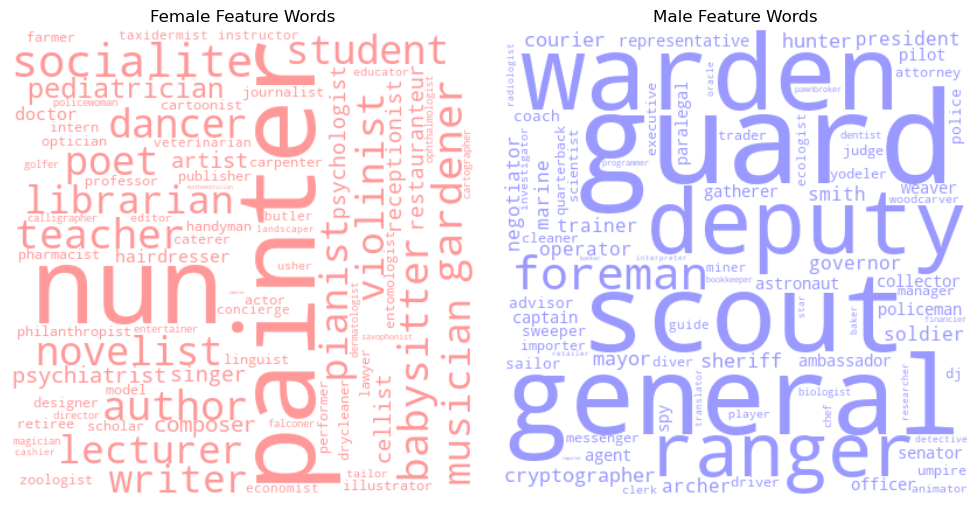

In [44]:
# draw wordcloud
word_sim_female = {word: sim for word, sim in similarity_diff.items()}
word_sim_male = {word: -sim for word, sim in similarity_diff.items()}

wordcloud_female = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: '#ff9999').generate_from_frequencies(word_sim_female)
wordcloud_male = WordCloud(width=400, height=400, background_color='white', color_func=lambda *args, **kwargs: '#9999ff').generate_from_frequencies(word_sim_male)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_female, interpolation='bilinear')
plt.title('Female Feature Words')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_male, interpolation='bilinear')
plt.title('Male Feature Words')
plt.axis('off')

plt.tight_layout()
plt.show()

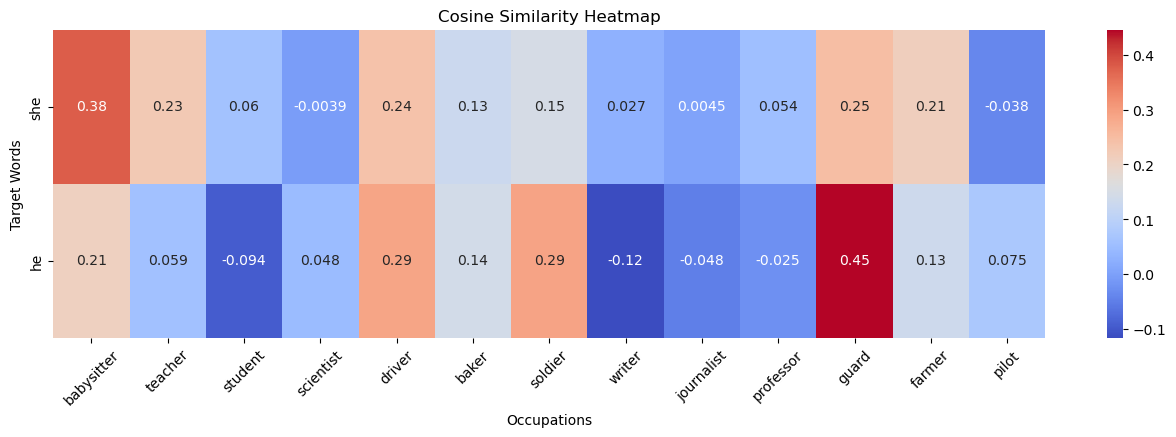

In [45]:
# heatmap
target_words = ["she", "he"]
target_words_vectors = np.array([
    vector_she,
    vector_he
])

occupation_samples = ["babysitter", "teacher", "student", "scientist", "driver", "baker", "soldier", "writer","journalist","professor",
              "guard", "farmer",  "pilot"]
occupation_samples_vectors = np.array([model.wv[occupation] for occupation in occupation_samples])

# cosine_similarity
cos_sim_matrix = cosine_similarity(np.vstack((target_words_vectors, occupation_samples_vectors)))
cos_sim_matrix = cos_sim_matrix[:2, 2:]

plt.figure(figsize=(16, 4))
sns.heatmap(cos_sim_matrix, annot=True, cmap='coolwarm', xticklabels=occupation_samples, yticklabels=target_words)
plt.title("Cosine Similarity Heatmap")
plt.ylabel("Target Words")
plt.xlabel("Occupations")
plt.xticks(rotation=45)  # for easy reading
plt.show()